In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

import os
import csv

## Workflow
The air quality data has already been processed from the UK-wide dataset from the MET Office to provide a the average air-quality readings for each Principal Urban Area (PUA) in the UK as a function of time. (Note, the processed data is provided in hourly increments.)

In this notebook we do the following analysis
* Choose an air-quality metric ("no2", "so2, "o3", "pm10")
* Import the processed data from the .csv files
* Check the content 
* Plot the hourly variation for all PUAs
* Apply a rolling-average filter of 1D and 7D and plot the variation for all PUAs
* Plot the rolling-average of the air quality metric across 5 key cities:
    + London, Manchester, Birmingham, Bristol, Liverpool

In [66]:
# Go to repository root directory
if "_changed_dir" not in locals():
    os.chdir("../")
    _changed_dir = True

In [67]:
#Parameters
csv_name = "no2_by_pua.csv" # <>_by_pua.csv -> options are "no2", "so2, "o3", "pm10"
data_dir = os.path.join("data", "processed")

#Mapping for MET Office names to short names
quantity_map= {
    "mean_mass_concentration_of_nitrogen_dioxide_in_air"    : "Average NO2", 
    "mean_mass_concentration_of_sulphur_dioxide_in_air"     : "Average SO2", 
    "mean_mass_concentration_of_ozone_in_air"               : "Average Ozone",
    "mean_mass_concentration_of_pm10_ambient_aerosol_in_air": "Average Particulates (< 10 micro-metres)"
}

In [68]:
csv_path = os.path.join(data_dir, csv_name)

In [69]:
#Get meta information (contained in the first two lines of the .csv)
with open(csv_path, newline='') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    quantity_list = next(csv_reader)
    unit_list     = next(csv_reader)
    
quantity = quantity_list[1]
units    = unit_list[1]

In [70]:
df       = pd.read_csv(csv_path, skiprows = 2)
df.index = pd.to_datetime(df.index, format='%d/%m/%Y %H:%M:%S')
df.head(10)

,Aberdeen,Blackburn,Bradford,Bournemouth,Birmingham,Brighton,Bristol,Burnley,Barnsley,Cambridge,...,Basildon,Telford,Middlesbrough,Warrington,Wakefield,Birkenhead,Wigan,Worthing,York,Belfast
2020-01-01 01:00:00,16.2139,19.2473,26.6197,3.6983,31.4529,26.6833,23.3387,22.6845,21.3241,25.760,...,31.2209,25.5168,16.4845,21.0130,23.7295,24.4133,21.0831,22.3176,18.3846,23.2418
2020-01-01 02:00:00,7.5519,19.5873,23.5472,3.8610,29.0946,24.5759,18.8427,20.8691,20.8517,27.040,...,28.1512,25.7446,15.5798,22.0246,22.3991,26.0200,21.7944,16.8941,16.6231,18.0443
2020-01-01 03:00:00,8.4190,18.6236,20.3268,4.4901,28.8669,20.3074,13.9095,17.7845,21.0845,29.270,...,24.9419,25.9188,15.0637,21.4739,21.8866,25.9011,20.9563,11.8941,15.5451,17.0338
2020-01-01 04:00:00,11.0785,19.8018,18.5220,5.9273,29.1101,13.5037,13.2759,17.2216,21.7612,29.300,...,22.7000,26.7921,15.6244,22.4565,22.3554,26.1800,22.2239,7.4529,16.2165,15.3209
2020-01-01 05:00:00,10.4038,21.6382,18.4205,7.7977,28.1463,10.8074,13.1016,18.3691,23.0147,26.705,...,22.2163,25.7812,14.7506,24.0609,23.5393,27.4800,24.2211,7.3529,17.5813,14.2303
2020-01-01 06:00:00,17.6810,24.6018,20.7772,11.3006,28.6214,10.9204,14.8897,21.1113,25.8129,25.305,...,23.4860,25.7000,14.2256,27.3522,26.5411,29.4189,27.6127,8.5176,19.3451,16.1761
2020-01-01 07:00:00,21.2165,29.7873,25.9795,15.8488,30.5179,14.6611,18.8379,25.6907,30.7586,24.660,...,26.0860,26.7891,16.9810,32.2348,32.2429,30.7189,32.6197,12.4529,22.6560,19.3547
2020-01-01 08:00:00,22.6038,36.4291,31.7268,20.1686,31.8751,18.4074,23.9170,31.9948,33.6147,24.770,...,27.7209,28.0693,23.8280,36.3304,36.8125,34.3100,37.6394,17.1941,29.1176,25.4607
2020-01-01 09:00:00,21.8557,39.7636,35.6008,20.4343,32.9058,20.0778,26.0747,36.4639,33.5121,24.035,...,28.0372,28.4168,27.0065,37.5319,37.5375,35.9711,39.0282,19.3529,33.0857,29.9318
2020-01-01 10:00:00,24.7734,37.1018,35.5189,17.4203,31.6840,21.0111,26.0901,35.4041,32.8121,23.680,...,27.2953,24.9297,30.6220,34.5000,35.5455,32.0467,35.8085,19.3059,34.1506,33.4139


In [71]:
#Get 'pretty' quantity names
quantity_name = [v for k, v in quantity_map.items() if k == quantity]
quantity_name = quantity_name[0]

## Plot the hourly variation for each PUA

Text(0, 0.5, 'Average NO2 [ug/m3]')

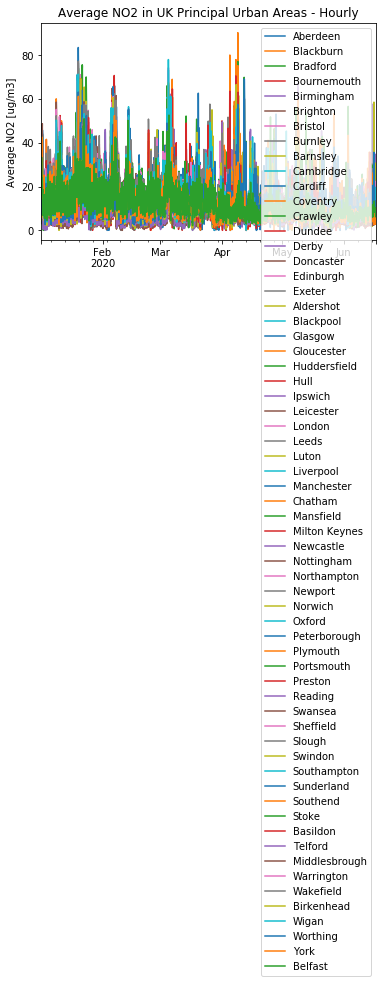

In [72]:
ax = df.plot()
ax.set_title(f"{quantity_name} in UK Principal Urban Areas - Hourly")
ax.set_ylabel(f"{quantity_name} [{units}]")

## Apply Rolling Average

Text(0, 0.5, 'Average NO2 [ug/m3]')

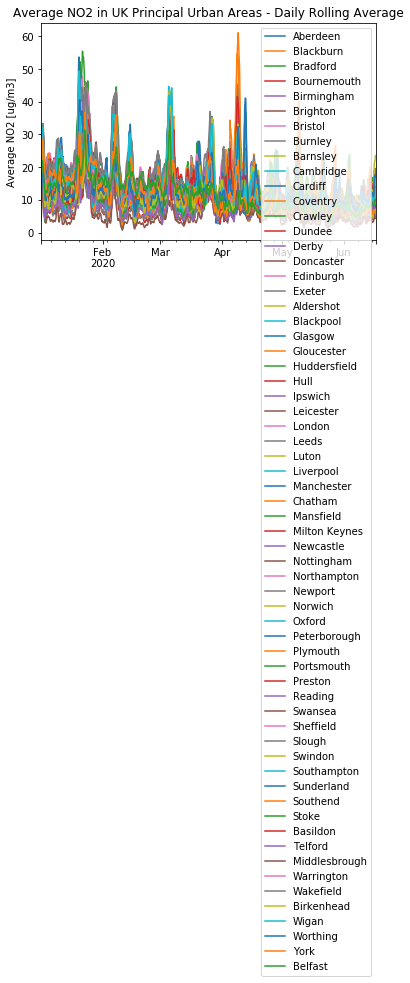

In [73]:
ax = df.rolling('1D').mean().plot()
ax.set_title(f"{quantity_name} in UK Principal Urban Areas - Daily Rolling Average")
ax.set_ylabel(f"{quantity_name} [{units}]")

Text(0, 0.5, 'Average NO2 [ug/m3]')

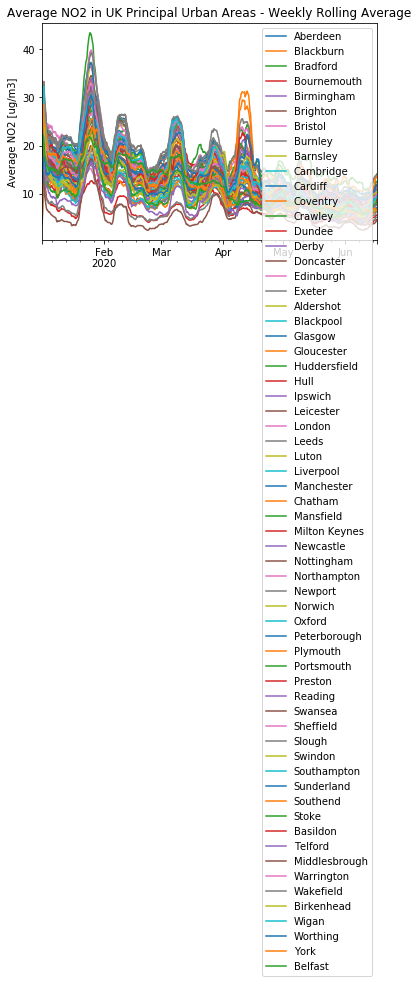

In [74]:
ax = df.rolling('7D').mean().plot()
ax.set_title(f"{quantity_name} in UK Principal Urban Areas - Weekly Rolling Average")
ax.set_ylabel(f"{quantity_name} [{units}]")

In [75]:
df_max = df.max(axis=1)
df_min = df.min(axis=1)

Text(0, 0.5, 'Average NO2 [ug/m3]')

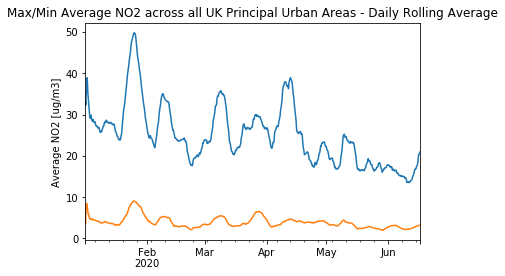

In [76]:
ax = df_max.rolling('7D').mean().plot(label='Maximum {} concentration')
ax = df_min.rolling('7D').mean().plot(label='Minimum {} concentration')
ax.set_title(f"Max/Min {quantity_name} across all UK Principal Urban Areas - Daily Rolling Average")
ax.set_ylabel(f"{quantity_name} [{units}]")

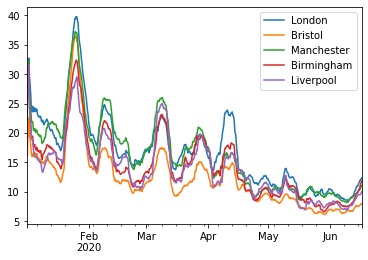

In [77]:
ax = df[['London', 'Bristol', 'Manchester', 'Birmingham', 'Liverpool']].rolling('7D').mean().plot()

Here we attempted to decompose the signal into seasonal components however there was no appreciable seasonality on a weekly basis. 

We require a longer time history of data in order to derive any measure of seasonality.

In [78]:
#seas_freq_val = 7
#decomposition = seasonal_decompose(df['London'].rolling('1D').mean(), period=seas_freq_val)
#fig = decomposition.plot() # assign to variable to avoid double plotting
#fig.savefig(os.path.join(save_dir, f'seasonal_decomposition_{smooth_str}{img_fmt}'))

## Findings
* Average NO2 across the main cities (London, Bristol, Manchester, Birmingham and Liverpool) have shown a steady reduction since the lockdown began, with some spikes around public holidays such as Easter.
* Average SO2 levels across the main cities do not show any discernable trends.
* Average Ozone levels have shown a steady increase since the start of the year.
* Particulate levels do not show any decrease due to lockdown.

This is an extremely rich data set that has only just begun to be explored. Further analysis of local effects is possible given the granular data provided by the MET Office. 

It is important to note that with all of these air-quality data sets it is not possible to account for seasonal (annual) variations as the data set only contains the previous six months to 01 Jan 2020. If a longer time history was available (such as for energy consumption) then an improved estimate of the air-quality reductions due to Covid-19 could be made.